In [1]:
import time
import requests
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

status_codes = requests.status_codes.codes

In [2]:
seasons = [str(year) for year in range(2000, 2007)]
print(seasons)

regression_columns = ['1B', '2B', '3B', 'HR', 'HBP+BB', 'SB', 'CS']
regression_2_columns = ['SLG', 'OBP']
target = 'R'

['2000', '2001', '2002', '2003', '2004', '2005', '2006']


In [3]:
not_integer_columns = ['Team']

float_columns = ['SLG', 'OBP']
header_columns = ['Team', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'OBP', 'SLG', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB']

def parse_standings_table(content):
    stats = []

    rows = BeautifulSoup(content).select('.stats_table tbody tr')
    for row in rows:
        if 'class' in row.attrs:
            continue

        columns = [row.select('th a')[0]] + row.select('td')

        observations = dict(
            zip(
                header_columns, 
                map(lambda a: a.text, [columns[0]] + columns[4:17] + columns[18:20] + columns[22:29])
            )    
        )

        stats.append(observations)

    df = pd.DataFrame(stats)
    for col in df.columns:
        if col in not_integer_columns:
            continue

        if col in float_columns:
            df[col] = df[col].astype(float)
        else:
            df[col] = df[col].astype(int)

    return df

In [4]:
def get_seasons(seasons, transformations):
    df = None

    for season in seasons:
        response = requests.get(f'https://www.baseball-reference.com/leagues/majors/{season}.shtml')

        if response.status_code != status_codes['ok']:
            raise Exception('no!!!!')

        df_season = parse_standings_table(response.content)
        df_season['Season'] = season

        if df is None:
            df = df_season
        else:
            df = pd.concat([df, df_season])

        time.sleep(5)

    for transformation in transformations:
        df = transformation(df)

    return df

In [5]:
def single(df):
    df['1B'] = df['H'] - (df['2B'] + df['3B'] + df['HR'])
    return df

def hbp_plus_bb(df):
    df['HBP+BB'] = df['HBP'] + df['BB']
    return df

def obp_plus_slg(df):
    df['OBP+SLG'] = df['OBP'] + df['SLG']
    return df

In [6]:
df = get_seasons(seasons, [
    single,
    hbp_plus_bb,
    obp_plus_slg,
])

df

,Team,G,PA,AB,R,H,2B,3B,HR,RBI,...,GDP,HBP,SH,SF,IBB,LOB,Season,1B,HBP+BB,OBP+SLG
0,Anaheim Angels,162,6373,5628,864,1574,309,34,236,837,...,126,47,47,43,43,1173,2000,995,655,0.824
1,Arizona Diamondbacks,162,6241,5527,792,1466,282,44,179,756,...,114,59,61,58,37,1128,2000,961,594,0.762
2,Atlanta Braves,162,6275,5489,810,1490,274,26,179,758,...,127,59,87,45,38,1192,2000,1011,654,0.775
3,Baltimore Orioles,162,6238,5549,794,1508,310,22,184,750,...,148,49,27,54,34,1129,2000,992,607,0.776
4,Boston Red Sox,162,6371,5630,792,1503,316,32,167,755,...,115,42,40,48,40,1226,2000,988,653,0.764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,St. Louis Cardinals,161,6225,5522,781,1484,292,27,184,745,...,129,61,71,40,70,1158,2006,981,592,0.768
26,Tampa Bay Devil Rays,162,6041,5474,689,1395,267,33,190,650,...,101,47,35,43,23,1038,2006,905,488,0.734
27,Texas Rangers,162,6273,5659,835,1571,357,23,183,799,...,148,40,18,50,35,1139,2006,1008,545,0.784
28,Toronto Blue Jays,162,6241,5596,809,1591,348,27,199,778,...,166,63,16,52,31,1162,2006,1017,577,0.811


In [7]:
corr = df[[target] + regression_columns].corr()
corr

,R,1B,2B,3B,HR,HBP+BB,SB,CS
R,1.000000,0.401195,0.496099,0.032766,0.706167,0.571083,-0.021730,-0.192413
1B,0.401195,1.000000,0.117431,0.187754,-0.131054,-0.089702,0.241762,0.083373
2B,0.496099,0.117431,1.000000,0.048697,0.232953,0.200195,-0.173421,-0.209413
3B,0.032766,0.187754,0.048697,1.000000,-0.229331,-0.205027,0.170891,0.212972
HR,0.706167,-0.131054,0.232953,-0.229331,1.000000,0.450345,-0.170997,-0.256777
HBP+BB,0.571083,-0.089702,0.200195,-0.205027,0.450345,1.000000,-0.104544,-0.221248
SB,-0.021730,0.241762,-0.173421,0.170891,-0.170997,-0.104544,1.000000,0.631109
CS,-0.192413,0.083373,-0.209413,0.212972,-0.256777,-0.221248,0.631109,1.000000


<AxesSubplot:>

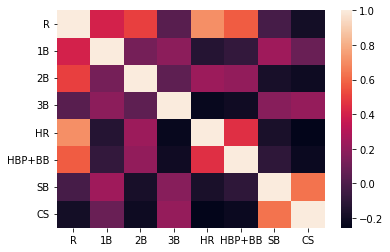

In [8]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [9]:
def setup_model(df, columns):
    y = df[target]
    X = sm.add_constant(df.loc[:, columns])

    return X, y

X, y = setup_model(df, regression_columns)

est = sm.OLS(y, X)
est = est.fit()

In [10]:
def print_summary(est, columns):
    print(est.summary())
    print()
    print('p-values')
    for i, column in enumerate(columns):
        print({column: (est.pvalues[i], est.pvalues[i] < .05)})

print_summary(est, X.columns)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     292.5
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          4.91e-102
Time:                        05:38:57   Log-Likelihood:                -965.48
No. Observations:                 210   AIC:                             1947.
Df Residuals:                     202   BIC:                             1974.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -563.0938     37.214    -15.131      0.0

In [11]:
df_pred = df.loc[:, ['Team', 'R']]

df_pred['PRED_R'] = est.predict(X)
df_pred['ABS_DIFF'] = (df_pred.R - df_pred.PRED_R).abs()

df_pred.head()

,Team,R,PRED_R,ABS_DIFF
0,Anaheim Angels,864,910.007256,46.007256
1,Arizona Diamondbacks,792,775.381101,16.618899
2,Atlanta Braves,810,802.605351,7.394649
3,Baltimore Orioles,794,801.751143,7.751143
4,Boston Red Sox,792,801.038834,9.038834


In [12]:
print('off by an average of:', df_pred.ABS_DIFF.mean(), 'runs')

off by an average of: 18.559531740609657 runs


### SLG / OBP contribution to runs scored

<AxesSubplot:xlabel='OBP+SLG', ylabel='R'>

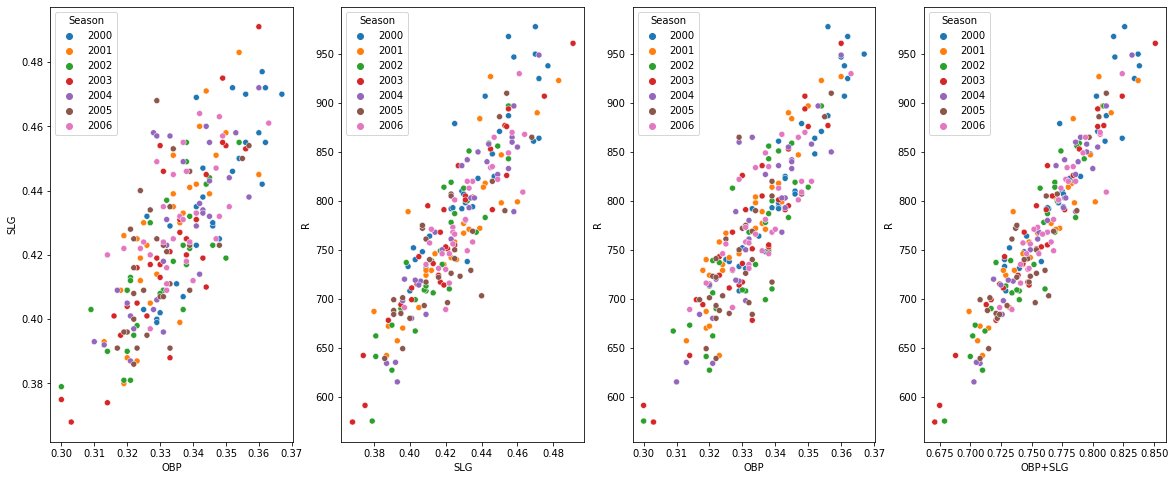

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

sns.scatterplot(ax=axes[0], data=df, x='OBP', y='SLG', hue='Season')
sns.scatterplot(ax=axes[1], data=df, x='SLG', y='R', hue='Season')
sns.scatterplot(ax=axes[2], data=df, x='OBP', y='R', hue='Season')
sns.scatterplot(ax=axes[3], data=df, x='OBP+SLG', y='R', hue='Season')

In [14]:
def setup_model(df, columns):
    y = df[target]
    X = sm.add_constant(df.loc[:, columns])

    return X, y

X, y = setup_model(df, regression_2_columns)

est = sm.OLS(y, X)
est = est.fit()

print_summary(est, X.columns)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     981.3
Date:                Tue, 27 Dec 2022   Prob (F-statistic):          2.45e-106
Time:                        05:38:59   Log-Likelihood:                -971.84
No. Observations:                 210   AIC:                             1950.
Df Residuals:                     207   BIC:                             1960.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -989.7912     45.426    -21.789      0.0